# Pytorch Computer Vision

## 0. Computer vision libraries in PyTorch

* `torchvision` - base domain library for PyTorch computer vision

* `torchvision.datasets` - get datasets and data loading functions for computer vision here

* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems

* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model

* `torch.utils.data.Dataset` - Base dataset class for PyTorch

* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

## 1. Getting a dataset

The dataset we'll be using is FashionMNIST from torchvision.datasets

In [3]:
# Setup training data
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None,
    download=True,
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None,
    download=True,
)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
# See the first training example
image, label = train_data[0]
image[0, 5], label

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0235, 0.0000, 0.4000, 0.8000, 0.6902, 0.5255,
         0.5647, 0.4824, 0.0902, 0.0000, 0.0000, 0.0000, 0.0000, 0.0471, 0.0392,
         0.0000]),
 9)

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### 1.1 Check input and output shapes of data

In [8]:
# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


### 1.2 Visualizing our data

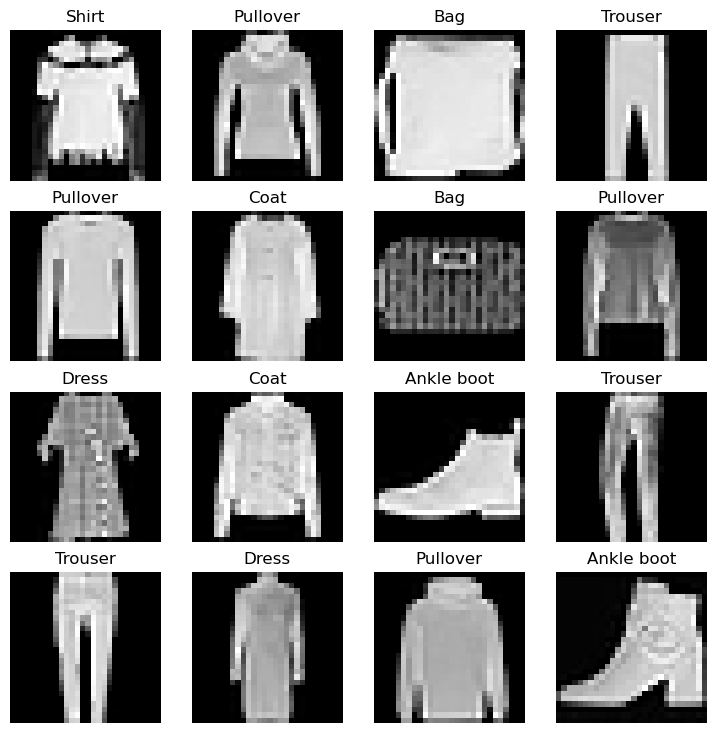

In [9]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

Recall: DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (or mini-batches).

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32).
2. It gives our neural network more chances to update its gradients per epoch. Instead of updating our gradients every 60000 images (so once per epoch), the optimizer updates the gradients every 32 images (no matter the epoch).

In [10]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

# Let's check out what we have created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of the train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7e4af59da780>, <torch.utils.data.dataloader.DataLoader object at 0x7e4af5ab43b0>)
Length of the train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [11]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 9, label size: torch.Size([])


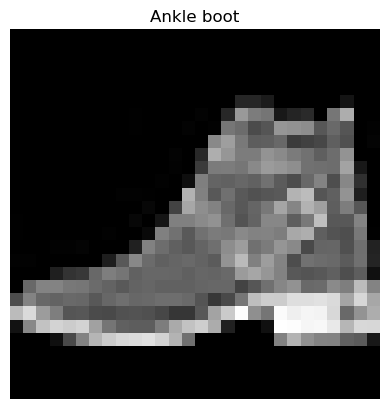

In [12]:
# Show a sample
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: Build a baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model. A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [13]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)   # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height * width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height * width]


In [14]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                    out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                    out_features=output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [15]:
# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to('cpu')

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [16]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[ 0.1709, -0.1088,  0.3071, -0.0844,  0.0721, -0.2660, -0.3317, -0.0969,
          0.2861, -0.1470]], grad_fn=<AddmmBackward0>)

In [17]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0025, -0.0086, -0.0208,  ..., -0.0018,  0.0236,  0.0186],
                      [ 0.0219,  0.0186, -0.0354,  ...,  0.0259,  0.0095, -0.0141],
                      [ 0.0316, -0.0210,  0.0111,  ...,  0.0203, -0.0217,  0.0211],
                      ...,
                      [ 0.0120,  0.0294, -0.0302,  ...,  0.0037,  0.0334,  0.0220],
                      [ 0.0302, -0.0241,  0.0240,  ...,  0.0351,  0.0234,  0.0057],
                      [ 0.0037, -0.0309, -0.0221,  ..., -0.0355, -0.0253,  0.0006]])),
             ('layer_stack.1.bias',
              tensor([ 0.0042, -0.0158, -0.0205, -0.0304, -0.0304, -0.0152, -0.0113,  0.0312,
                       0.0036, -0.0121])),
             ('layer_stack.2.weight',
              tensor([[ 0.2904, -0.2911, -0.3116, -0.2412,  0.0679,  0.1792,  0.1105,  0.0027,
                        0.2860, -0.0491],
                      [-0.0934, -0.1313, -0.2340, -0.0616,  0.2190, -0.2297, -0.

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`

* Optimizer - our optimizer `torch.optim.SGD()` (stochastic gradient descent)

* Evaluation metric - since we are working on a classification problem, let's use accuracy as

In [18]:
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1)

### 3.2 Creating a function to time our experiments

Machine learning is very experimental.

Two of the main things you'll often want to track are:
1. Model's performance (loss, accuracy, etc)
2. How fast it runs

In [19]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### 3.3 Creating a training loop and training a mode on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all (for fun).

In [20]:
from tqdm.auto import tqdm

# Start the timer to measure training duration
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")

    ### Training
    train_loss = 0

    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate the loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X_test)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y_test)

            # 3. Calculate accuracy
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)

        # Calculate the test acc average per batch
        test_acc /= len(test_dataloader)

    # Print out what's happening
    print(f"\n Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}\n")

# Calculate the training time
train_time_end_on_cpu = timer()
total_train_time_model_0_cpu = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu, device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

 Train loss: 0.5899 | Test loss: 0.5175, Test acc: 0.2796

Epoch: 1
--------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

 Train loss: 0.4784 | Test loss: 0.5270, Test acc: 0.2796

Epoch: 2
--------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

 Train loss: 0.4552 | Test loss: 0.5248, Test acc: 0.2995

Train time on cpu: 14.652 seconds


## 4. Make predictions and get Model 0 results

In [21]:
for i, (X, y) in enumerate(test_data):
    print(torch.tensor(y))

    if i == 4:
        break

tensor(9)
tensor(2)
tensor(1)
tensor(1)
tensor(6)


In [22]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.dataloader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss +=loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # this only works when the model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5248347520828247,
 'model_acc': 80.99041533546325}

## 5. Setup device agnostic-code (for using a GPU if there is one)

In [23]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 6. Model 1: Building a better model with non-linearity

In [24]:
# Create a model with linear and non-linear layers
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # flatten inputs into a single vector
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

# Create an instance of model_1
model_1 = FashionMNISTModelV1(input_shape=28*28,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
next(model_1.parameters()).device

device(type='cpu')

## 6.1 Setup loss, optimizer and evaluation metrics

In [25]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() # measure how wrong our model is
optimizer = torch.optim.SGD(params=model_1.parameters(),  # tries to update our model's parameters to reduce the loss
                            lr=0.1)

### 6.2 Functionizing training and evaluation/testing loop

Let's create a function for:
* training loop - `train_step()`

* testing loop - `test_step()`

In [26]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
  """Performs a training with model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss  # accumulate train loss per batch
    train_acc += accuracy_fn(y_true=y,
                              y_pred=y_pred.argmax(dim=1))  # go from logits -> prediction labels

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [27]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0, 0

  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manageer
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (outputs raw logits)
      test_pred = model(X)

      # 2. Calculate the loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction labels

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [28]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.dataloader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make our data device agnostic
            X, y = X.to(device), y.to(device)

            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss +=loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # this only works when the model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [29]:
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1_gpu = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 1.19607 | Train acc: 60.60%
Test loss: 1.11490 | Test acc: 62.24%

Epoch: 1
--------
Train loss: 1.07861 | Train acc: 63.36%
Test loss: 1.06003 | Test acc: 63.49%

Epoch: 2
--------
Train loss: 1.05633 | Train acc: 63.72%
Test loss: 1.13165 | Test acc: 61.99%

Train time on cpu: 14.235 seconds


**Note:** Sometimes, depending on your data/hardware, you might find that your model trains faster on CPU than GPU.

Why is this?

1. It could be that the overhead for copying data/model to and from the GPU outweights the compute benefits offered by the GPU.
2. The hardware you're using has a better CPU in terms compute capability than the GPU.

For more on how to make your models compute faster, see here: https://horace.io/brrr_intro.html

In [30]:
# Get model_1 results dictionary
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 1.1316466331481934,
 'model_acc': 61.99081469648562}

In [31]:
model_0_results, total_train_time_model_0_cpu

({'model_name': 'FashionMNISTModelV0',
  'model_loss': 0.5248347520828247,
  'model_acc': 80.99041533546325},
 14.652384869999878)

## Model 2: Building a Convolutional Neural Network (CNN)

CNN's are also known as ConvNets.

CNN's are known for their capabilities to find patterns in visual data.

To find out what's happening inside a CNN, see this website: https://poloclub.github.io/cnn-explainer/

In [32]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """Model architecture that replicates the TinyVGG model from CNN explainer website"""
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output shape of conf_block_2: {x.shape}")
        x = self.classifier(x)
        # print(f"Output shape of classifier: {x.shape}")
        return x

In [33]:
image.shape

torch.Size([1, 28, 28])

In [34]:
model_2 = FashionMNISTModelV2(input_shape=1,    # number of color channels
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [35]:
image.shape

torch.Size([1, 28, 28])

tensor([[ 0.0205,  0.0114, -0.0224, -0.0339, -0.0471,  0.0726,  0.0151,  0.0409,
          0.0423, -0.0462]], grad_fn=<AddmmBackward0>)

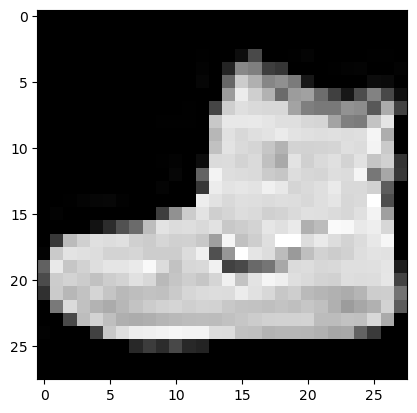

In [36]:
plt.imshow(image.squeeze(), cmap="gray")

# Try forward pass
model_2(image.unsqueeze(0))

### 7.1 Stepping through `nn.Conv2d`

In [37]:
# Create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])


In [38]:
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=(3, 3),
                       stride=1,
                       padding=1)

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 64, 64])

### 7.2 Stepping through `nn.MaxPool2d()`

In [39]:
# Print out the original image shape
print(f"Test image shape: {test_image.shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image)
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image shape: torch.Size([3, 64, 64])
Shape after going through conv_layer(): torch.Size([10, 64, 64])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([10, 32, 32])


In [40]:
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 2, 2))

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
max_pool_tensor.shape

torch.Size([1, 1, 1])

### 7.3 Setup a loss function and optimizer

In [41]:
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

### 7.4 Training and testing `model_2` using our training and test functions

In [42]:
# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(train_time_start_model_2, 
                                            train_time_end_model_2,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.60527 | Train acc: 78.04%
Test loss: 0.46529 | Test acc: 82.89%

Epoch: 1
------
Train loss: 0.34784 | Train acc: 87.47%
Test loss: 0.38910 | Test acc: 85.91%

Epoch: 2
------
Train loss: 0.31220 | Train acc: 88.74%
Test loss: 0.34085 | Test acc: 88.16%

Train time on cpu: 40.894 seconds


In [43]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

print(f"Model 0 results: {model_0_results}")
print(f"Model 2 results: {model_2_results}")

  0%|          | 0/313 [00:00<?, ?it/s]

Model 0 results: {'model_name': 'FashionMNISTModelV0', 'model_loss': 0.5248347520828247, 'model_acc': 80.99041533546325}
Model 2 results: {'model_name': 'FashionMNISTModelV2', 'model_loss': 0.3408486545085907, 'model_acc': 88.15894568690096}


## 8. Compare model results and training time

In [44]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.524835,80.990415
1,FashionMNISTModelV1,1.131647,61.990815
2,FashionMNISTModelV2,0.340849,88.158946


In [45]:
# Add training time to results comparison
compare_results["training_time"] = [total_train_time_model_0_cpu,
                                    total_train_time_model_1_gpu,
                                    total_train_time_model_2]

compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.524835,80.990415,14.652385
1,FashionMNISTModelV1,1.131647,61.990815,14.235013
2,FashionMNISTModelV2,0.340849,88.158946,40.893690


Text(0, 0.5, 'model')

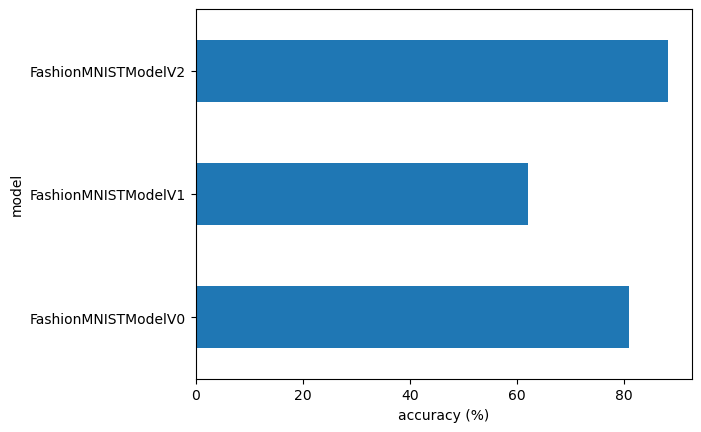

In [46]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")  # barh = horizontal bar chart
plt.xlabel("accuracy (%)")
plt.ylabel("model")

## 9. Make and evaluate random predictions with best model

In [47]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # Get predicion probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

Text(0.5, 1.0, 'Bag')

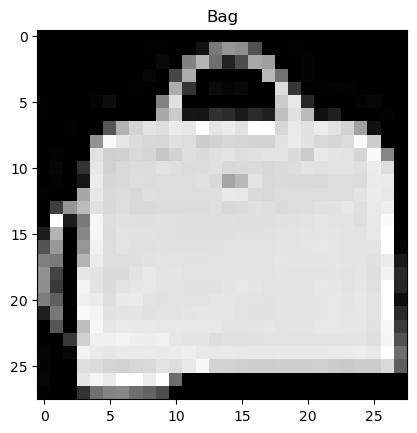

In [48]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first sample shape
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [49]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples,
                              device=device)

# View first two prediction probabilities
pred_probs[:2]

tensor([[2.1873e-05, 1.8609e-08, 4.2991e-05, 1.0257e-07, 1.2077e-04, 6.4281e-09,
         3.1795e-06, 1.4119e-07, 9.9981e-01, 1.2029e-07],
        [1.1189e-04, 1.8292e-05, 9.8898e-01, 1.6144e-06, 1.6709e-03, 7.3362e-07,
         9.2121e-03, 1.1999e-06, 1.9516e-06, 2.1644e-06]])

In [50]:
# Convert prediciton probabilities to label
pred_classes = pred_probs.argmax(dim=1)
pred_classes, test_labels

(tensor([8, 2, 0, 7, 7, 1, 5, 2, 4]), [8, 2, 0, 7, 7, 1, 5, 2, 4])

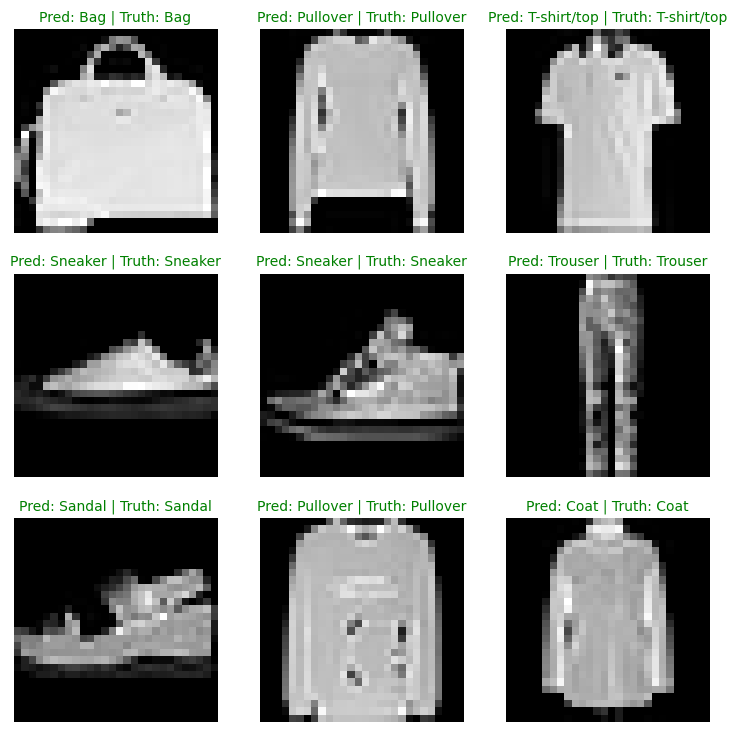

In [51]:
# Prot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap=("gray"))

    # Find the prediction (in text form, e.g "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = class_names[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check fo requality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")   # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)

## 10. Making a confusion matrix for further prediction

A confusion matrix is a fantastic way of evaluating your classification models visually:
https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation

1. Make predictions with our trained model on the test dataset

2. Make a confusion matrix `torchmetrics.ConfusionMatrix` - https://lightning.ai/docs/torchmetrics/stable/classification/confusion_matrix.html

3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()` -https://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

In [58]:
# 1. Make predictions with our trained model on the test dataset
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        # Send the data and targets to target device
        X, y = X.to(device), y.to(device)

        # Do the forward pass
        y_logits = model_2(X)

        # Turn predictions from logits -> prediction probabilites -> prediction labels
        y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)

        # Put prediction on CPU for evaluation
        y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
len(y_pred_tensor)

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

10000

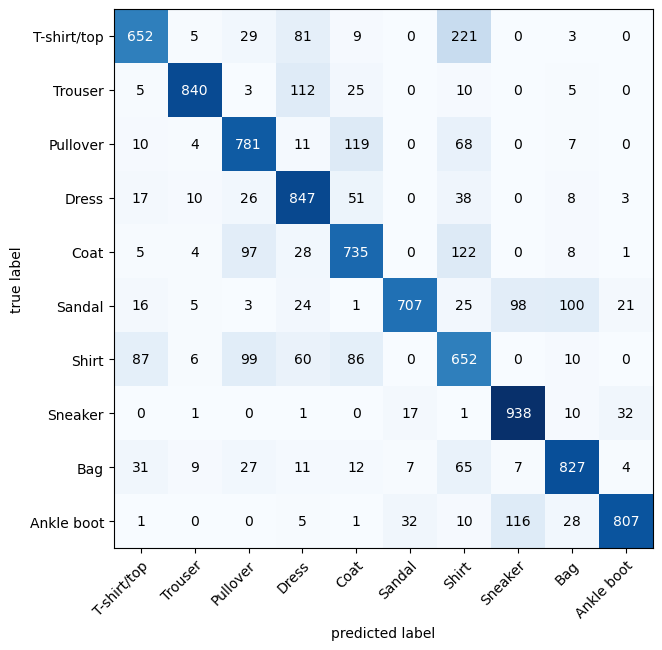

In [67]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot our confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),    # matplotlib likes working with numpy
    class_names=class_names,
    figsize=(10, 7)
)

## 11. Save and load best performing model

In [72]:
from pathlib import Path

# Create a model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "03_fashionMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/03_fashionMNIST.pth


In [76]:
# Create a new instance
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))

# Load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [77]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3408486545085907,
 'model_acc': 88.15894568690096}

In [78]:
# Evaluate loaded model
loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3408486545085907,
 'model_acc': 88.15894568690096}

In [79]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08)

tensor(True)